In [2]:
using MKL # for intel CPU
using DifferentialEquations, LinearAlgebra, SparseArrays, Symbolics, Peaks;
using CSV,DataFrames,JSON
using GLMakie, PyCall

PyCall.pygui_start(:qt_pyqt5)
sns = pyimport("seaborn")
pd = pyimport("pandas")
plt = pyimport("matplotlib.pyplot")
optimize = pyimport("scipy.optimize")

Makie.inline!(true)

true

# Core diffusion model

We want to simulate a model according to this equation: 
$$
\begin{aligned}
\frac{\partial L}{\partial t} &= D \nabla^2 L - \gamma_L L
\end{aligned}
$$
Note that this equation will be slightly different if cells are positioned on 2D plane and diffusion and degradation happens in 3D. (Check supplement for details)

## Set the parameters and simulation space (2D-3D)

In [2]:
"""
    div_2d3d(N_r, N_z, r_max, z_max)

This function creates a Laplacian matrix for cells in 2D diffusion in 3D (cylindrical coordinates).

# Arguments
- `N_r`: Number of grid points in the radial direction.
- `N_z`: Number of grid points in the axial direction.
- `r_max`: Maximum value of the radial coordinate.
- `z_max`: Maximum value of the axial coordinate.

# Returns
- `mat_div`: Laplacian matrix for the given grid.

"""
function div_2d3d(N_r, N_z, r_max, z_max)
    rd = range(0, stop=r_max, length=N_r)
    zd = range(0, stop=z_max, length=N_z)
    dr = step(rd)
    dz = step(zd)
    translate_2d3d_to_1d(ir, iz) = (iz - 1) * N_r + ir
    ir_indices = Int[]
    jc_indices = Int[]
    data_values = Float64[]
    for ir in 1:N_r
        r = rd[ir]
        for iz in 1:N_z
            center_idx = translate_2d3d_to_1d(ir, iz)
            center_val = 0.
            # Radial parts
            if ir > 1 # Left neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir - 1, iz))
                push!(data_values, 1/dr^2 - 1/(2*dr*r))
            end
            if ir < N_r # Right neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir + 1, iz))
                if ir != 1
                    push!(data_values, 1/dr^2 + 1/(2*dr*r))
                else
                    push!(data_values, 1/dr^2)
                end
                # push!(data_values, 1/dr^2 + 1/(2*dr*r))
            end
            if ir != 1
                center_val -= 1/(dr^2)
            end

            # Axial parts
            if iz > 1 # Below neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir, iz - 1))
                push!(data_values, 1/dz^2)
            end
            if iz < N_z # Above neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir, iz + 1))
                push!(data_values, 1/dz^2)
            end

            # Center position, adjusted for radial dependence
            center_val -= (1/dr^2 + 2/dz^2) 
            push!(ir_indices, center_idx)
            push!(jc_indices, center_idx)
            push!(data_values, center_val)
        end
    end

    # Construct the sparse matrix
    mat_div = sparse(ir_indices, jc_indices, data_values)
    return mat_div
end

div_2d3d

In [3]:


#Environment setup: 
l_mul = 10 #length unit multiplier, changing it won't affect the results
t_mul = 100 #time unit multiplier, changing it won't affect the results
r_limit = 50*l_mul #500 microns in simulation radius
z_limit = 50*l_mul #500 microns in simulation height (in this model the co-permissive cue diffuses more rapidly so it needs higher z_limit)
r_cell = 0.015*l_mul # 0.15 micron is the simulation grid size
r_inputsource = 1*l_mul # 10 microns is the source size
H = 0.1*l_mul # 1 micron is the source height
N_r = 500 # 400
N_z = 500 # 500
mat_div = div_2d3d(N_r,N_z,r_limit,z_limit);
rgrid = range(0,stop = r_limit,length = N_r)
zgrid = range(0,stop = z_limit, length = N_z)

dr = step(rgrid)
dz = step(zgrid)

zs = repeat(zgrid,inner = N_r)
ir_max = ceil(Int,r_inputsource/dr)+1
iz_min = floor(Int,(z_limit/2 - H/2)/dz)
iz_max = floor(Int,(z_limit/2 + H/2)/dz)+1

delta(z,H) = 1/(2H)*sqrt(2/pi)*exp(-z^2 / (2*H^2)); #1D Gaussian distribution, function to mimic delta function on the z axis
deltaz_vec = delta.(zs .- z_limit/2,H)
deltar(r,R) = 1/(R^2)*exp(-r^2 /(R^2)); #2D Gaussian distribution in polar coordinates
source_T(t,S0,S_l) = (t >= 0)*(t <= S_l)*S0;

translate_2d3d_to_1d(ir,iz,N_r) = (iz - 1)*N_r + ir;


"""
    hill_f(N, K, h)

Compute the Hill function value for given parameters.

# Arguments
- `N`: The input value.
- `K`: The Hill coefficient.
- `h`: The Hill exponent.

# Returns
- The computed Hill function value.

"""
function hill_f(N,K,h)
    if h > 0
        return N^h /(N^h + K^h)
    else
        return 1*(N > K)
    end
end

function corediffuse_2d3d_diff(dX,X,ps,t)
    # ODEs with hill functions
    D, gammaL, S_on, S_len = ps 
    # D = D/(dx^2)
    @inbounds dX[:] =  D*mat_div*X[:] .- gammaL*X[:]
    if S_on > 0. && t < S_len
        @inbounds for ir in 1:ir_max
        for iz in iz_min:iz_max
            dX[translate_2d3d_to_1d(ir,iz,N_r)] += S_on
        end
        end
    end
end


function initL_2d3d(rd,zd,S_int,r_source, R0)
    #initialization of the concentration field
    N_r = length(rd)
    N_z = length(zd)
    source_Trz(r,z,t,S0) = deltar(r,r_source)*delta(z - z_limit/2,H)*(t >= 0)*S0; #source in the center
    u = zeros(N_r*N_z,1)
    for I in CartesianIndices((N_r, N_z))
        r = rd[I[1]]
        z = zd[I[2]]
        u[translate_2d3d_to_1d(I[1],I[2],N_r)] = source_Trz(r,z,1.,S_int)
    end
    u
end

initL_2d3d (generic function with 1 method)

In [4]:

DL = 1.5*1e3*l_mul^2 /t_mul 
#Cond set:


gammaL = 0.05/t_mul#Decay rate 
#Units are scaled but otherwise set here: 
sam = 1e6 #Input source strength, without units, 0 means no input after initialization
S_len = 2.0*t_mul #Duration of input source

S_on = sam/(t_mul^2*l_mul^3) #Input strength, constant emmisssion, with units

#Parameter set to pass to model
ps_temp = DL, gammaL, S_on, S_len 


r_source = 3*l_mul #Initial source size
s_init = 0.#Initial source amplitude, set to be zero
#Setting initatal conditions and building model space: 
X02d3d = initL_2d3d(rgrid, zgrid, s_init, r_source, 0.0);
dX02d3d= copy(X02d3d);

In [5]:
jac_sparsity_corediffuse_2d3d = Symbolics.jacobian_sparsity((dX,X)->corediffuse_2d3d_diff(dX,X,ps_temp,1),dX02d3d,X02d3d); # For utlizing sparsity in the Jacobian

## Running the simulation

In [6]:
#solve the model
t_end = 5.0*t_mul
savedt = 0.01*t_mul
f0 = ODEFunction(corediffuse_2d3d_diff;jac_prototype=float.(jac_sparsity_corediffuse_2d3d));
corediffuse_2d3d_sparse = ODEProblem(f0,X02d3d,(0.0,t_end),ps_temp); #Setup ODE problem:
corediffuse_2d3d_sol = solve(corediffuse_2d3d_sparse, Rodas5P(), saveat = savedt); 

In [7]:
size(corediffuse_2d3d_sol) #Check the size of the solution

(250000, 1, 501)

## View the results

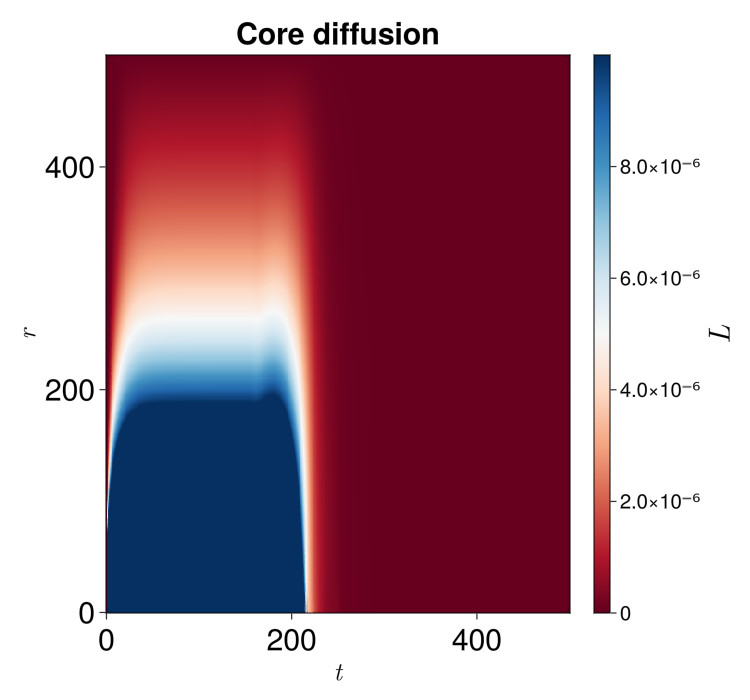

In [10]:
corediffuse_plane_sol = corediffuse_2d3d_sol[translate_2d3d_to_1d.(1:N_r,ceil(Int,N_z/2),N_r),:,:] #Get the solution at the z=0 plane
N_t = size(corediffuse_plane_sol, 3)
ts = 0:savedt:savedt*(N_t-1)
# Plotting the heatmap
fig = Figure(fontsize = 30, resolution = (750, 700))
ax = Axis(fig[1,1],title="Core diffusion", xlabel = L"t", ylabel = L"r",xaxisposition = :bottom)
ax.xlabelsize = 25
ax.ylabelsize = 25
m = heatmap!(ax,ts, rgrid, corediffuse_plane_sol[1:N_r,1,:]', colormap=:RdBu,colorrange=(0,1e-5))
Colorbar(fig[1,2], m , vertical = true, label = L"L",ticklabelsize=20)
fig

# Co-permissive model

We want to simulate a model according to this equation: 
$$
\begin{aligned}
\frac{\partial F}{\partial t} &= D_F \nabla^2 F - \gamma_F F \\
\frac{\partial L}{\partial t} &= D_L \nabla^2 L + a\rho \frac{F^m}{F^m+F_0^m}\frac{L^n}{L^n+L_0^n} - \gamma_L L
\end{aligned}
$$
Note that this equation will be slightly different if cells are positioned on 2D plane and diffusion and degradation happens in 3D. (Check supplement for details)

## Set the parameters and simulation space (2D-3D)

In [3]:
"""
    div_2d3d(N_r, N_z, r_max, z_max)

This function creates a Laplacian matrix for cells in 2D diffusion in 3D (cylindrical coordinates).

# Arguments
- `N_r`: Number of grid points in the radial direction.
- `N_z`: Number of grid points in the axial direction.
- `r_max`: Maximum value of the radial coordinate.
- `z_max`: Maximum value of the axial coordinate.

# Returns
- `mat_div`: Laplacian matrix for the given grid.

"""
function div_2d3d(N_r, N_z, r_max, z_max)
    rd = range(0, stop=r_max, length=N_r)
    zd = range(0, stop=z_max, length=N_z)
    dr = step(rd)
    dz = step(zd)
    translate_2d3d_to_1d(ir, iz) = (iz - 1) * N_r + ir
    ir_indices = Int[]
    jc_indices = Int[]
    data_values = Float64[]
    for ir in 1:N_r
        r = rd[ir]
        for iz in 1:N_z
            center_idx = translate_2d3d_to_1d(ir, iz)
            center_val = 0.
            # Radial parts
            if ir > 1 # Left neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir - 1, iz))
                push!(data_values, 1/dr^2 - 1/(2*dr*r))
            end
            if ir < N_r # Right neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir + 1, iz))
                if ir != 1
                    push!(data_values, 1/dr^2 + 1/(2*dr*r))
                else
                    push!(data_values, 1/dr^2)
                end
                # push!(data_values, 1/dr^2 + 1/(2*dr*r))
            end
            if ir != 1
                center_val -= 1/(dr^2)
            end

            # Axial parts
            if iz > 1 # Below neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir, iz - 1))
                push!(data_values, 1/dz^2)
            end
            if iz < N_z # Above neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir, iz + 1))
                push!(data_values, 1/dz^2)
            end

            # Center position, adjusted for radial dependence
            center_val -= (1/dr^2 + 2/dz^2) 
            push!(ir_indices, center_idx)
            push!(jc_indices, center_idx)
            push!(data_values, center_val)
        end
    end

    # Construct the sparse matrix
    mat_div = sparse(ir_indices, jc_indices, data_values)
    return mat_div
end

div_2d3d

In [4]:


#Environment setup: 
l_mul = 10 #length unit multiplier, changing it won't affect the results
t_mul = 100 #time unit multiplier, changing it won't affect the results
r_limit = 50*l_mul #500 microns in simulation radius
z_limit = 50*l_mul #500 microns in simulation height (in this model the co-permissive cue diffuses more rapidly so it needs higher z_limit)
r_cell = 0.015*l_mul # 0.15 micron is the simulation grid size
r_inputsource = 1*l_mul # 10 microns is the source size
H = 0.1*l_mul # 1 micron is the source height
N_r = 500 # 400
N_z = 500 # 500
mat_div = div_2d3d(N_r,N_z,r_limit,z_limit);
rgrid = range(0,stop = r_limit,length = N_r)
zgrid = range(0,stop = z_limit, length = N_z)

dr = step(rgrid)
dz = step(zgrid)

zs = repeat(zgrid,inner = N_r)
ir_max = ceil(Int,r_inputsource/dr)+1
iz_min = floor(Int,(z_limit/2 - H/2)/dz)
iz_max = floor(Int,(z_limit/2 + H/2)/dz)+1

delta(z,H) = 1/(2H)*sqrt(2/pi)*exp(-z^2 / (2*H^2)); #1D Gaussian distribution, function to mimic delta function on the z axis
deltaz_vec = delta.(zs .- z_limit/2,H)
deltar(r,R) = 1/(R^2)*exp(-r^2 /(R^2)); #2D Gaussian distribution in polar coordinates
source_T(t,S0,S_l) = (t >= 0)*(t <= S_l)*S0;

translate_2d3d_to_1d(ir,iz,N_r) = (iz - 1)*N_r + ir;


"""
    hill_f(N, K, h)

Compute the Hill function value for given parameters.

# Arguments
- `N`: The input value.
- `K`: The Hill coefficient.
- `h`: The Hill exponent.

# Returns
- The computed Hill function value.

"""
function hill_f(N,K,h)
    if h > 0
        return N^h /(N^h + K^h)
    else
        return 1*(N > K)
    end
end

function copermissive_2d3d_diff(dX,X,ps,t)
    # ODEs with hill functions
    DF, DL, F0, L0, a, rho, gammaF, gammaL, S_on, S_len = ps 
    # D = D/(dx^2)
    @inbounds dX[:,1] =  DF*mat_div*X[:,1] .- gammaF*X[:,1]
    @inbounds dX[:,2] = DL*mat_div*X[:,2] .+ a*rho*hill_f.(X[:,1],F0,10).*hill_f.(X[:,2],L0,10).*deltaz_vec*2 - gammaL*X[:,2]
    if S_on > 0. && t < S_len
        @inbounds for ir in 1:ir_max
        for iz in iz_min:iz_max
            dX[translate_2d3d_to_1d(ir,iz,N_r),1] += S_on
            dX[translate_2d3d_to_1d(ir,iz,N_r),2] += S_on
        end
        end
    end
end


function init_2d3d(rd,zd,S_int,r_source, R0)
    #initialization of the concentration field
    N_r = length(rd)
    N_z = length(zd)
    source_Trz(r,z,t,S0) = deltar(r,r_source)*delta(z - z_limit/2,H)*(t >= 0)*S0; #source in the center
    u = zeros(N_r*N_z,2)
    for I in CartesianIndices((N_r, N_z))
        r = rd[I[1]]
        z = zd[I[2]]
        u[translate_2d3d_to_1d(I[1],I[2],N_r),1] = source_Trz(r,z,1.,S_int)
        u[translate_2d3d_to_1d(I[1],I[2],N_r),2] = R0
    #   u[I] = 27*(x*(1-x))^(3/2)
    end
    u
end

init_2d3d (generic function with 1 method)

In [5]:

DF = 1.5*1e3*l_mul^2 /t_mul 
DL = 0.05*1e3*l_mul^2 /t_mul 
#Cond set:


gammaF = 0.05/t_mul #Decay rate 
gammaL = 0.05/t_mul#Decay rate 
#Units are scaled but otherwise set here: 
a = 1.2/t_mul #Relay strength term, effectively 

sam = 1e6 #Input source strength, without units, 0 means no input after initialization
S_len = 2.0*t_mul #Duration of input source

rho = 1.0/l_mul^2 #2D density of cells
S_on = sam/(t_mul^2*l_mul^3) #Input strength, constant emmisssion, with units

F0 = 0.003/l_mul^3 #Threshold for F
L0 = 0.03/l_mul^3 #Threshold for L
#Parameter set to pass to model
ps_temp = DF, DL, F0, L0, a, rho, gammaF, gammaL, S_on, S_len 


r_source = 3*l_mul #Initial source size
s_init = 0.#Initial source amplitude, set to be zero
#Setting initatal conditions and building model space: 
X02d3d = init_2d3d(rgrid, zgrid, s_init, r_source, 0.0);
dX02d3d= copy(X02d3d);

In [143]:
sqrt(2*3*DL*200)

244.94897427831782

In [169]:
(2*a*rho/(pi*L0))

2.546479089470326

In [25]:
jac_sparsity_2d3d_prac = Symbolics.jacobian_sparsity((dX,X)->copermissive_2d3d_diff(dX,X,ps_temp,1),dX02d3d,X02d3d); # For utlizing sparsity in the Jacobian

## Running simulation

In [181]:
#solve the model
t_end = 5.0*t_mul
savedt = 0.01*t_mul
f = ODEFunction(copermissive_2d3d_diff;jac_prototype=float.(jac_sparsity_2d3d_prac));
copermissive_2d3d_sparse = ODEProblem(f,X02d3d,(0.0,t_end),ps_temp); #Setup ODE problem:
copermissive_2d3d_sol = solve(copermissive_2d3d_sparse, Rodas5P(), saveat = savedt); 

## Save the results

In [182]:
model = "co-permissive"
# model = "pedagogical"
folder = "pulse fit experiments"*string("_",model)
filename = string("Son-", round(S_on,sigdigits = 3),"_F0-", round(F0,sigdigits = 3), "_L0-", round(L0,sigdigits=3), "_DF-", round(DF,sigdigits=3),"_DL-", round(DL,sigdigits=3),"_a-", round(a,sigdigits=3))
filepath = joinpath(folder, string(filename,".csv") )
params_filepath = joinpath(folder, string(filename,"_params.json"))
# Create the folder if it does not exist
if !isdir(folder)
    mkdir(folder)
end
#save plane solution to filepath
plane_sol = copermissive_2d3d_sol[translate_2d3d_to_1d.(1:N_r,ceil(Int,N_z/2),N_r),:,:] #Get the solution at the z=0 plane

reshaped_plane_sol = reshape(plane_sol, (size(plane_sol, 1)*size(plane_sol, 2) , size(plane_sol, 3))) #Reshape the solution to be a 2D array
sol_df = DataFrame(reshaped_plane_sol, :auto)
rename!(sol_df, [Symbol("ti=$(i)") for i in 1:size(sol_df, 2)])
CSV.write(filepath , sol_df)
#save parameters to params_filepath

params_dict = Dict("DL" => DL,"DF"=>DF, "a" => a, "F0" => F0, "L0" => L0, "rho" => rho, "gammaF" => gammaF, "gammaL" => gammaL, "S_on" => S_on, "S_len" => S_len, "r_source" => r_source, "model" => model,"dr" =>dr, "dt"=> savedt)

open(params_filepath, "w") do file
    write(file, JSON.json(params_dict))
end


210

## Read the results

In [6]:

model = "co-permissive"
folder = "pulse fit experiments"*string("_",model)
filename = string("Son-", round(S_on,sigdigits = 3),"_F0-", round(F0,sigdigits = 3), "_L0-", round(L0,sigdigits=3), "_DF-", round(DF,sigdigits=3),"_DL-", round(DL,sigdigits=3),"_a-", round(a,sigdigits=3))

filepath = joinpath(folder, string(filename,".csv") )
params_filepath = joinpath(folder, string(filename,"_params.json"))
#read parameters from params_filepath
params_dict = JSON.parsefile(params_filepath)
L0 = params_dict["L0"]
F0 = params_dict["F0"]
dr = params_dict["dr"]
savedt = params_dict["dt"]
plane_sol_df = CSV.read(filepath, DataFrame)

"""
    wave_front_r(plane_sol_at_t, dr, S_cri)

This function calculates the wave front position at a given time, given that the wave front is defined as the position where the concentration is equal to S_cri.

# Arguments
- `plane_sol_at_t`: An array representing the concentration values at a given time.
- `dr`: The spatial step size.
- `S_cri`: The critical concentration value.

# Returns
- If the wave front is not found (concentration values are below S_cri), it returns 0.
- If the wave front is found, it returns the position of the wave front.

"""
function wave_front_r(plane_sol_at_t, dr, S_cri)
    N_r = Int(length(plane_sol_at_t))
    ix = findlast(plane_sol_at_t[1:N_r] .> S_cri)
    if ix == nothing
        return 0
    else
        return ix*dr
    end
end


wave_front_r

In [7]:
size(plane_sol_df, 1)

1000

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/echo/.julia/packages/Makie/VRavR/src/scenes.jl:220


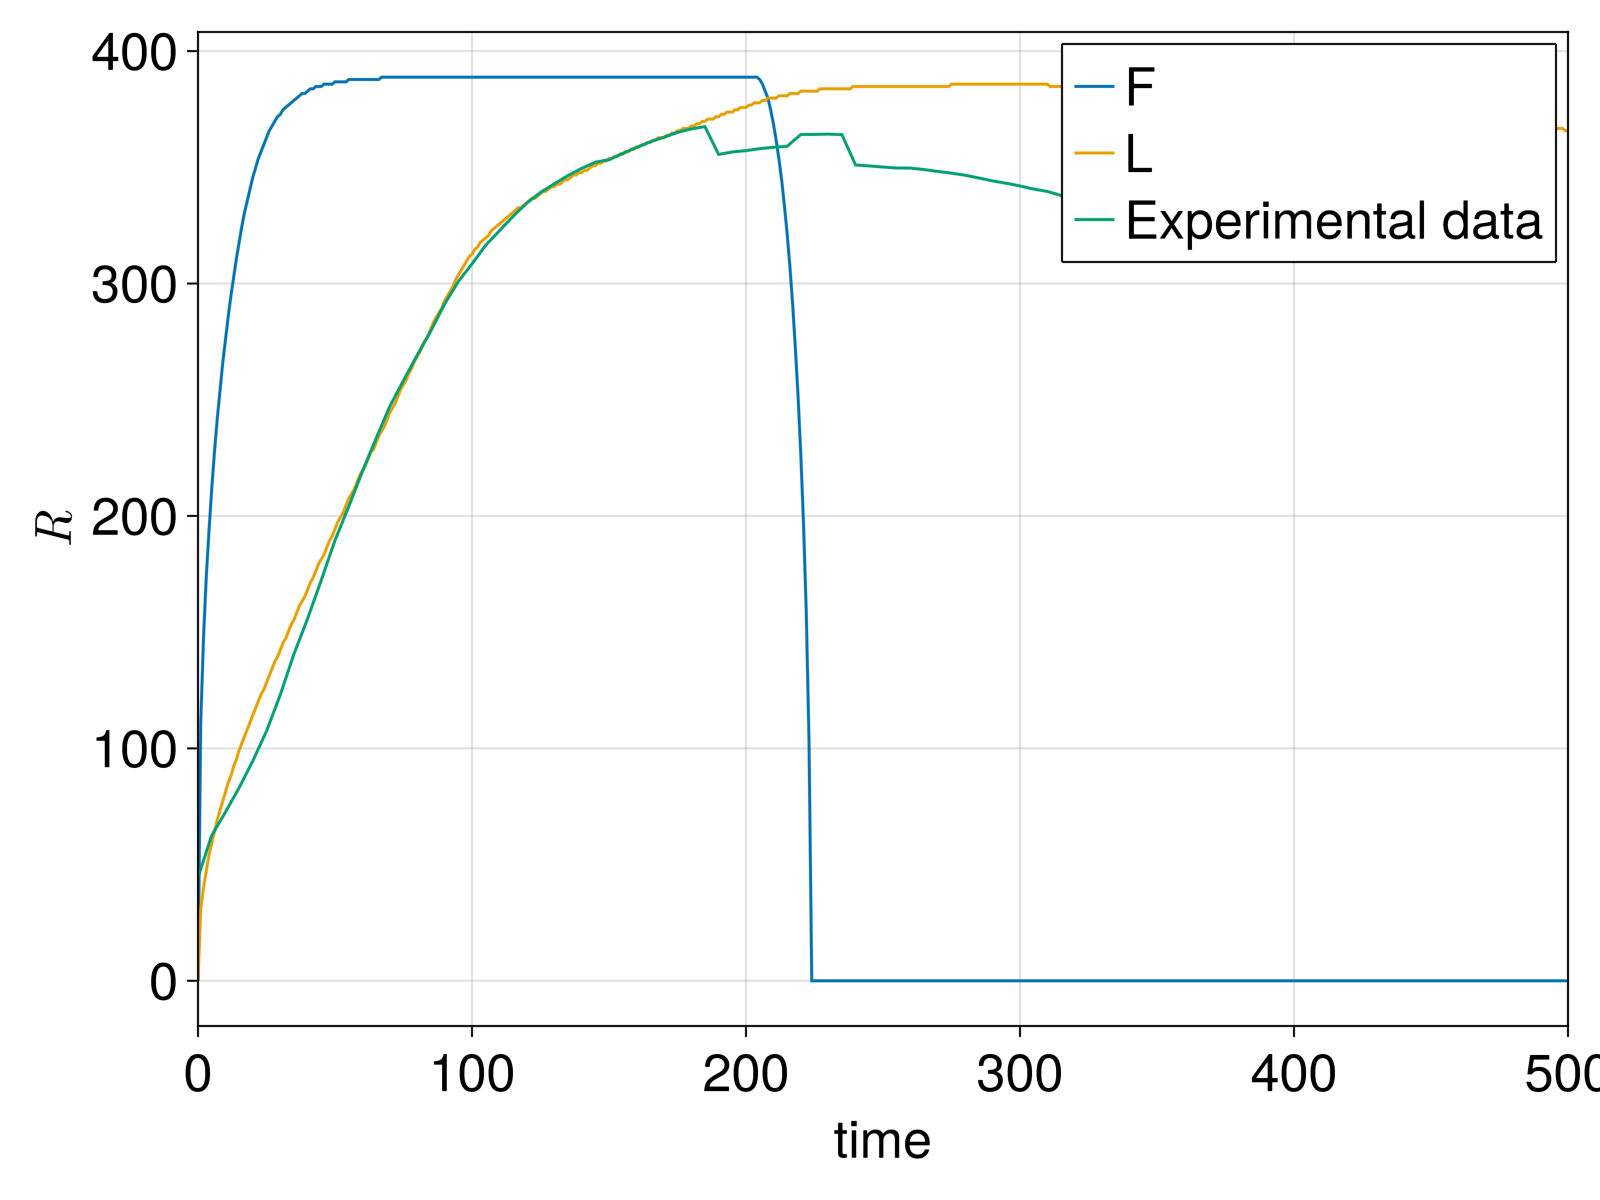

In [7]:
using LaTeXStrings
exp_data = CSV.read("Fig3d_largest-waves-mean-radius-v-time.csv", DataFrame)
# plot(exp_data[:,:real_time],exp_data[:,:relative_radius], xlab = "Time (sec)", ylab = "Relative radius", label="Experimental data(relative)",lw = 2)

N_t = size(plane_sol_df, 2)
N_r = Int(size(plane_sol_df, 1)/2)
ts = 0:savedt:savedt*(N_t-1)
r_F = [wave_front_r(plane_sol_df[1:N_r,ti], dr , F0/2) for ti in 1:N_t]
r_L = [wave_front_r(plane_sol_df[N_r+1:end,ti], dr , L0) for ti in 1:N_t]

fig = Figure(resolution=(800,600),fontsize=26)
ax = Axis(fig[1,1], title = " ", xlabel = "time", ylabel = L"R")

lines!(ax, ts, r_F,label="F",lw = 2)
lines!(ax, ts, r_L,label="L",lw = 2)
lines!(ax, exp_data[:,:real_time],exp_data[:,:circle_radius], label="Experimental data",lw = 2)
xlims!(ax,0,savedt*(N_t-1))
axislegend(ax, position = :rt, merge = true)
#plot!(ylim=(0,250000))
fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/echo/.julia/packages/Makie/VRavR/src/scenes.jl:220


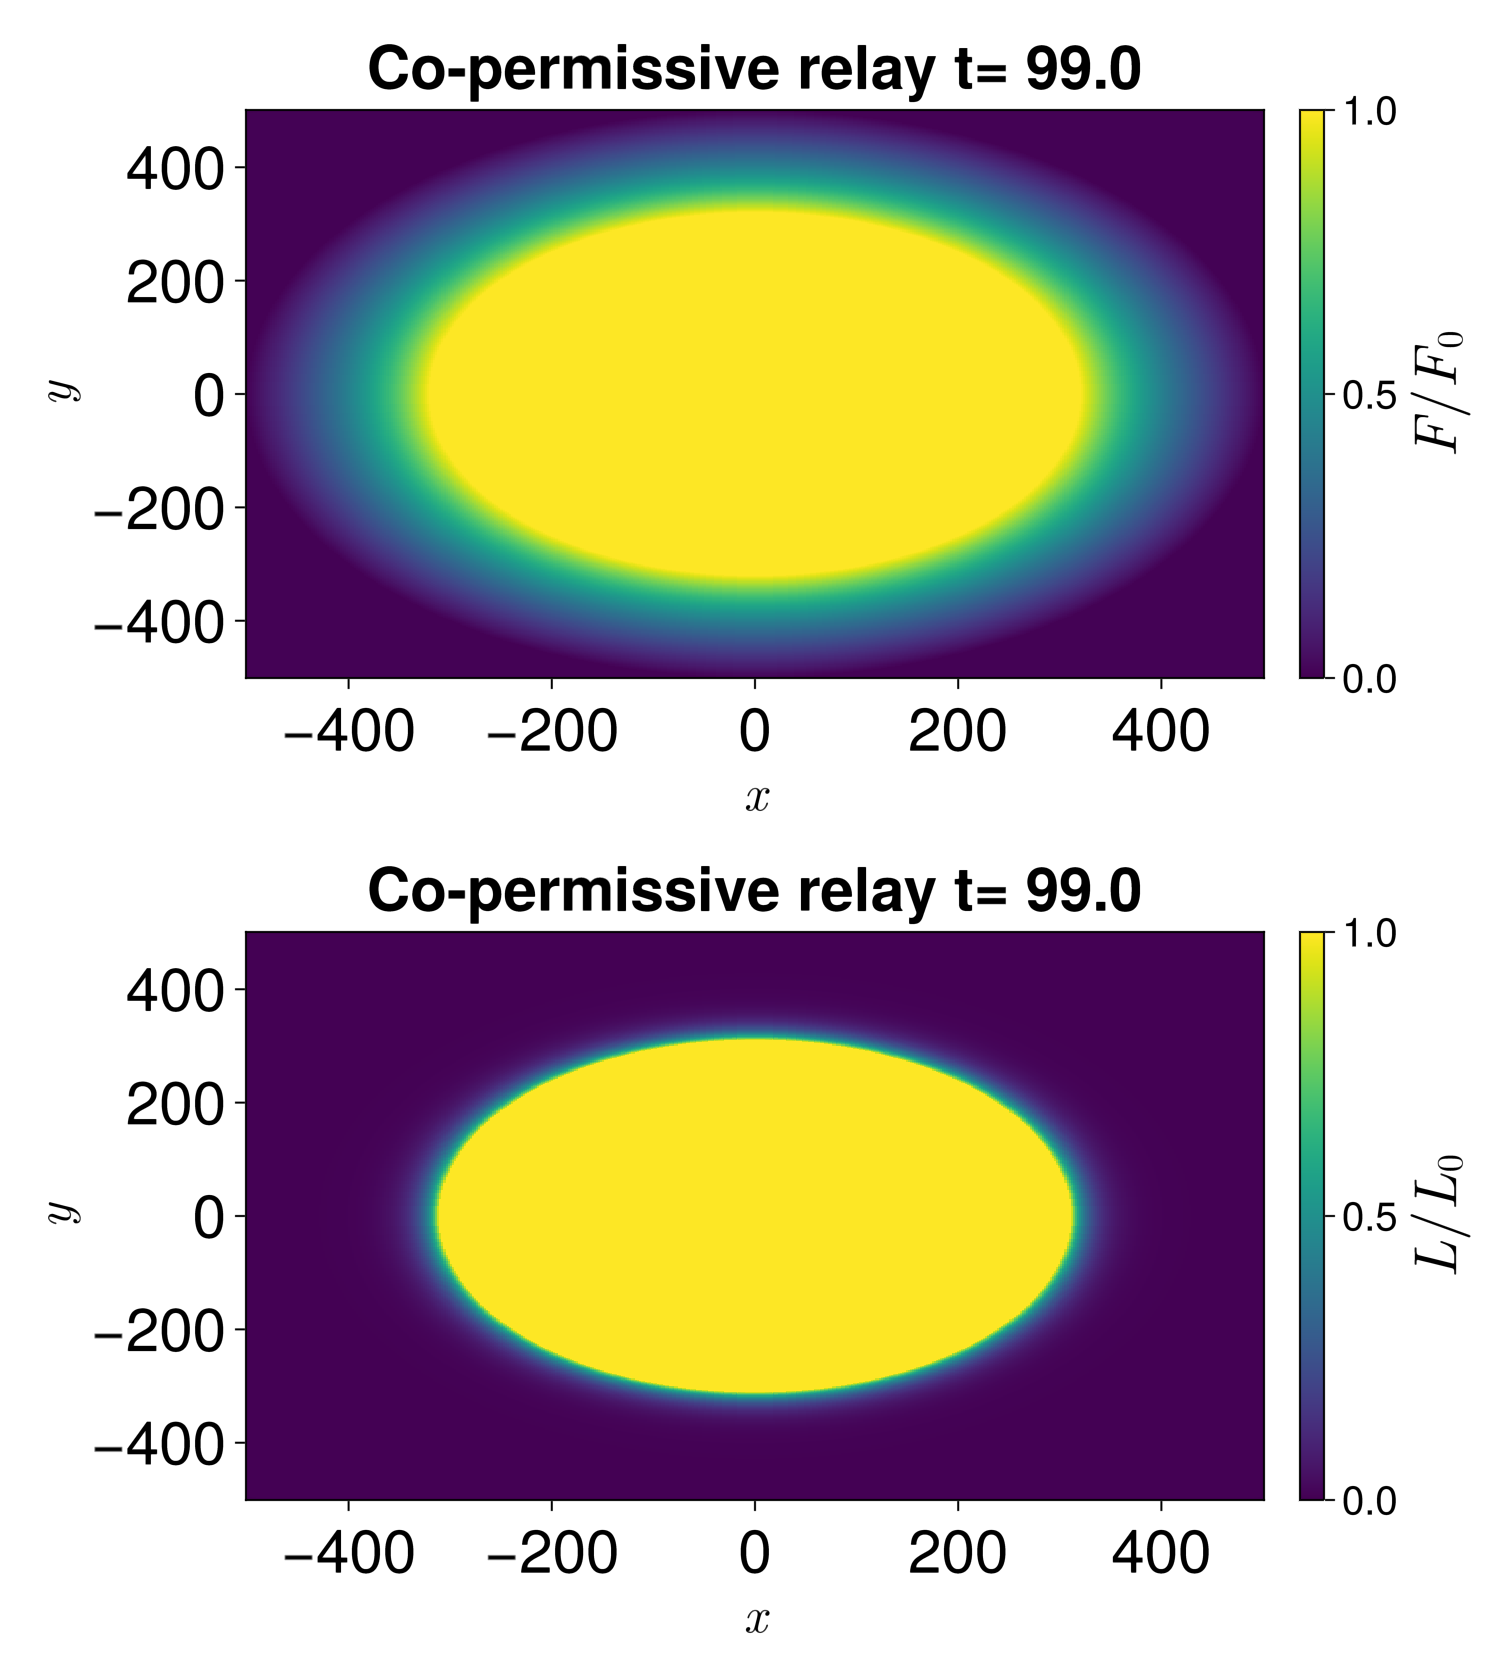

In [8]:
ti = 100
r_values = 0.0:dr:dr*(N_r-1) 

# Create a grid for x and y values
n = length(r_values)
x_values = LinRange(-maximum(r_values), maximum(r_values), n)
y_values = LinRange(-maximum(r_values), maximum(r_values), n)
x_grid, y_grid = [x for x in x_values, y in y_values], [y for x in x_values, y in y_values]

# Convert the 1D polar data to a 2D Cartesian grid 
"""
    polar_to_cartesian(density, r_values, x_values, y_values)

Converts polar coordinates to cartesian coordinates.

# Arguments
- `density`: A vector of density values.
- `r_values`: A vector of radial values.
- `x_values`: A vector of x-coordinate values.
- `y_values`: A vector of y-coordinate values.

# Returns
- `cartesian_data`: A 2D array representing the cartesian data.

"""
function polar_to_cartesian(density, r_values, x_values, y_values)
    n = length(r_values)
    cartesian_data = zeros(Float64, n, n)

    for i in 1:n
        for j in 1:n
            r = sqrt(x_values[j]^2 + y_values[i]^2)
            # Find the closest index in r_values to this r
            _, idx = findmin(abs.(r_values .- r))
            cartesian_data[i, j] = density[idx]
        end
    end
    return cartesian_data
end

cartesian_Fdata = polar_to_cartesian(plane_sol_df[1:N_r,ti], r_values, x_values, y_values)
cartesian_Ldata = polar_to_cartesian(plane_sol_df[N_r+1:end,ti], r_values, x_values, y_values)

# Plotting the heatmap
fig = Figure(fontsize = 30, resolution = (750, 1300))
ax = Axis(fig[1,1],title="Co-permissive relay t= $(ts[ti])", xlabel = L"x", ylabel = L"y",xaxisposition = :bottom)
ax.xlabelsize = 25
ax.ylabelsize = 25
m = heatmap!(ax,x_values, y_values, cartesian_Fdata./F0, colormap=:viridis,colorrange=(0,1))
Colorbar(fig[1,2], m , vertical = true, label = L"F/F_0",ticklabelsize=20)

ax2 = Axis(fig[2,1],title="Co-permissive relay t= $(ts[ti])", xlabel = L"x", ylabel = L"y",xaxisposition = :bottom)
ax2.xlabelsize = 25
ax2.ylabelsize = 25
m2 = heatmap!(ax2,x_values, y_values, cartesian_Ldata./L0, colormap=:viridis,colorrange=(0,1))
Colorbar(fig[2,2], m2 , vertical = true, label = L"L/L_0",ticklabelsize=20)

fig

In [11]:
# Plotting the L heatmap

for ti in 2:10:252
    cartesian_Ldata = polar_to_cartesian(plane_sol_df[N_r+1:end,ti], r_values, x_values, y_values)

    # Plotting the heatmap
    fig, ax = plt.subplots(figsize=(3,3))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    sns.heatmap(data=cartesian_Ldata,cmap="Blues", cbar=false, vmin=0, vmax=L0*10.0, square=true, xticklabels=false, yticklabels=false)
    circle1 = plt.Circle([250,250], r_L[ti]*0.5, color="#3B76B0", fill=false, linestyle="--", linewidth=5)
    ax.add_patch(circle1)
    plt.xlim(0,500)
    plt.ylim(0,500)
    plt.xlabel("")
    plt.ylabel("")
    plt.savefig("heatmaps/L/fig4-supp_co-permL_$ti.png", dpi=300)
    plt.close()
end

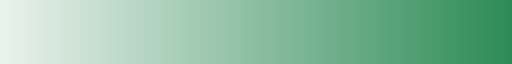

In [12]:
green_cmap = sns.light_palette("seagreen", as_cmap=true)

In [13]:
#Plotting the F heatmap

for ti in 2:10:252
    cartesian_Fdata = polar_to_cartesian(plane_sol_df[1:N_r,ti], r_values, x_values, y_values)

    # Plotting the heatmap
    fig, ax = plt.subplots(figsize=(3,3))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    sns.heatmap(data=cartesian_Fdata,cmap=green_cmap, cbar=false, vmin=F0, vmax=F0*10.0, square=true, xticklabels=false, yticklabels=false)
    circle1 = plt.Circle([250,250], r_F[ti]*0.5, color="#587B74", fill=false, linestyle="--", linewidth=5)
    ax.add_patch(circle1)
    plt.xlim(0,500)
    plt.ylim(0,500)
    plt.xlabel("")
    plt.ylabel("")
    plt.savefig("heatmaps/F/fig4-supp_co-permF_$ti.png", dpi=300)
    plt.close()
end

# Two-wave model

We want to simulate a model according to this equation: 
$$
\begin{aligned}
\frac{\partial L}{\partial t} &= D \nabla^2 L + a\rho\theta(L-L_0) - (\gamma_c \rho \theta(R-L) + \gamma_L) L\\
\frac{\partial R}{\partial t} &= D \nabla^2 R + b\rho \theta(L-L_0) - \gamma_R R
\end{aligned}
$$
To mimic the step function with smooth functions, we simulate the model using this equation
$$
\begin{aligned}
\frac{\partial L}{\partial t} &= D \nabla^2 L + a\rho\frac{L^m}{L^m+L_0^m}- \left( \frac{\gamma_c \rho}{1+ \exp({-\alpha(R-L)})} + \gamma_L\right) L\\
\frac{\partial R}{\partial t} &= D \nabla^2 R + b\rho \frac{L^m}{L^m+L_0^m} - \gamma_R R
\end{aligned}
$$

Note that this equation will be slightly different if cells are positioned on 2D plane and diffusion and degradation happens in 3D.

## 2D-3D Simulation

### Set the parameters and simulation space

In [187]:
"""
    div_2d3d(N_r, N_z, r_max, z_max)

This function creates a Laplacian matrix for cells in 2D diffusion in 3D (cylindrical coordinates).

# Arguments
- `N_r`: Number of grid points in the radial direction.
- `N_z`: Number of grid points in the axial direction.
- `r_max`: Maximum value of the radial coordinate.
- `z_max`: Maximum value of the axial coordinate.

# Returns
- `mat_div`: Laplacian matrix for the given grid.

"""
function div_2d3d(N_r, N_z, r_max, z_max)
    rd = range(0, stop=r_max, length=N_r)
    zd = range(0, stop=z_max, length=N_z)
    dr = step(rd)
    dz = step(zd)
    translate_2d3d_to_1d(ir, iz) = (iz - 1) * N_r + ir
    ir_indices = Int[]
    jc_indices = Int[]
    data_values = Float64[]
    for ir in 1:N_r
        r = rd[ir]
        for iz in 1:N_z
            center_idx = translate_2d3d_to_1d(ir, iz)
            center_val = 0.
            # Radial parts
            if ir > 1 # Left neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir - 1, iz))
                push!(data_values, 1/dr^2 - 1/(2*dr*r))
            end
            if ir < N_r # Right neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir + 1, iz))
                if ir != 1
                    push!(data_values, 1/dr^2 + 1/(2*dr*r))
                else
                    push!(data_values, 1/dr^2)
                end
                # push!(data_values, 1/dr^2 + 1/(2*dr*r))
            end
            if ir != 1
                center_val -= 1/(dr^2)
            end

            # Axial parts
            if iz > 1 # Below neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir, iz - 1))
                push!(data_values, 1/dz^2)
            end
            if iz < N_z # Above neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir, iz + 1))
                push!(data_values, 1/dz^2)
            end

            # Center position, adjusted for radial dependence
            center_val -= (1/dr^2 + 2/dz^2) 
            push!(ir_indices, center_idx)
            push!(jc_indices, center_idx)
            push!(data_values, center_val)
        end
    end

    # Construct the sparse matrix
    mat_div = sparse(ir_indices, jc_indices, data_values)
    return mat_div
end

div_2d3d

In [232]:

#Environment setup: 
l_mul = 10 #length unit multiplier, changing it won't affect the results
t_mul = 100 #time unit multiplier, changing it won't affect the results
r_limit = 50*l_mul #500 microns in simulation radius
z_limit = 5*l_mul #50 microns in simulation height 
r_cell = 0.015*l_mul # 0.15 micron is the simulation grid size
r_inputsource = 1*l_mul # 10 microns is the source size
H = 0.1*l_mul # 1 micron is the source height
N_r = 500 # 400
N_z = 125 # 500
mat_div = div_2d3d(N_r,N_z,r_limit,z_limit);
rgrid = range(0,stop = r_limit,length = N_r)
zgrid = range(0,stop = z_limit, length = N_z)

dr = step(rgrid)
dz = step(zgrid)

zs = repeat(zgrid,inner = N_r)
ir_max = ceil(Int,r_inputsource/dr)+1
iz_min = floor(Int,(z_limit/2 - H/2)/dz)
iz_max = floor(Int,(z_limit/2 + H/2)/dz)+1

delta(z,H) = 1/(2H)*sqrt(2/pi)*exp(-z^2 / (2*H^2)); #1D Gaussian distribution, function to mimic delta function on the z axis
deltaz_vec = delta.(zs .- z_limit/2,H)
deltar(r,R) = 1/(R^2)*exp(-r^2 /(R^2)); #2D Gaussian distribution in polar coordinates
source_T(t,S0,S_l) = (t >= 0)*(t <= S_l)*S0;

translate_2d3d_to_1d(ir,iz,N_r) = (iz - 1)*N_r + ir;


"""
    hill_f(N, K, h)

Compute the Hill function value for given parameters.

# Arguments
- `N`: The input value.
- `K`: The Hill coefficient.
- `h`: The Hill exponent.

# Returns
- The computed Hill function value.

"""
function hill_f(N,K,h)
    if h > 0
        return N^h /(N^h + K^h)
    else
        return 1*(N > K)
    end
end

function step_f(x,alpha)
    return 1.0/(1 + exp(-alpha*x))
end

function twowave_2d3d_diff(dX,X,ps,t)
    # ODEs with hill functions
    D, L0, a, rho, alpha, gammaC, gammaL, gammaR, S_on, S_len = ps 
    # D = D/(dx^2)
    @inbounds dX[:,1] =  D*mat_div*X[:,1] .+ (a*hill_f.(X[:,1],L0,10).- gammaC*step_f.(X[:,2]-X[:,1],alpha).*X[:,1])*rho.*deltaz_vec*2 .- gammaL*X[:,1]
    @inbounds dX[:,2] = D*mat_div*X[:,2] .+ b*rho*hill_f.(X[:,1],L0,10).*deltaz_vec*2 .- gammaR*X[:,2]
    if S_on > 0. && t < S_len
        @inbounds for ir in 1:ir_max
        for iz in iz_min:iz_max
            dX[translate_2d3d_to_1d(ir,iz,N_r),1] += S_on
            # dX[translate_2d3d_to_1d(ir,iz,N_r),2] += S_on
        end
        end
    end
end


function init_2d3d(rd,zd,S_int,r_source, R0)
    #initialization of the concentration field
    N_r = length(rd)
    N_z = length(zd)
    source_Trz(r,z,t,S0) = deltar(r,r_source)*delta(z - z_limit/2,H)*(t >= 0)*S0; #source in the center
    u = zeros(N_r*N_z,2)
    for I in CartesianIndices((N_r, N_z))
        r = rd[I[1]]
        z = zd[I[2]]
        u[translate_2d3d_to_1d(I[1],I[2],N_r),1] = source_Trz(r,z,1.,S_int)
        u[translate_2d3d_to_1d(I[1],I[2],N_r),2] = R0
    #   u[I] = 27*(x*(1-x))^(3/2)
    end
    u
end

init_2d3d (generic function with 1 method)

In [368]:

D = 0.07*1e3*l_mul^2 /t_mul 
#Cond set:


gammaR = 0.05/t_mul #Decay rate
gammaL = 0.5/t_mul#Decay rate 
gammaC = 10.0/t_mul*l_mul^3 #Decay rate
#Units are scaled but otherwise set here: 
a = 2.5/t_mul #Relay strength term, effectively (a*p from paul model) a = 0.025*t_mul*l_mul^2 
b = 20.0/t_mul 
alpha = 4.0*l_mul^3

sam = 1e5 #Input source strength, without units, 0 means no input after initialization
S_len = 0.1*t_mul #Duration of input source

rho = 1.0/l_mul^2 #2D density of cells
S_on = sam/(t_mul^2*l_mul^3) #Input strength, constant emmisssion, with units

L0 = 0.03/l_mul^3 #Threshold for L
#Parameter set to pass to model
ps_temp = D, L0, a, rho, alpha, gammaC, gammaL, gammaR, S_on, S_len 

r_source = 3*l_mul #Initial source size
s_init = 0.#Initial source amplitude, set to be zero
#Setting initatal conditions and building model space: 
X02d3d = init_2d3d(rgrid, zgrid, s_init, r_source, 0.0);
dX02d3d= copy(X02d3d);

In [234]:
jac_sparsity_2d3d_twowave = Symbolics.jacobian_sparsity((dX,X)->twowave_2d3d_diff(dX,X,ps_temp,1),dX02d3d,X02d3d); # For utlizing sparsity in the Jacobian

### Running simulation

In [369]:
#solve the model
t_end = 5.0*t_mul
savedt = 0.01*t_mul
f2 = ODEFunction(twowave_2d3d_diff;jac_prototype=float.(jac_sparsity_2d3d_twowave));
twowave_2d3d_sparse = ODEProblem(f2,X02d3d,(0.0,t_end),ps_temp); #Setup ODE problem:
twowave_2d3d_sol = solve(twowave_2d3d_sparse, Rodas5P(), saveat = savedt); 

### View the results

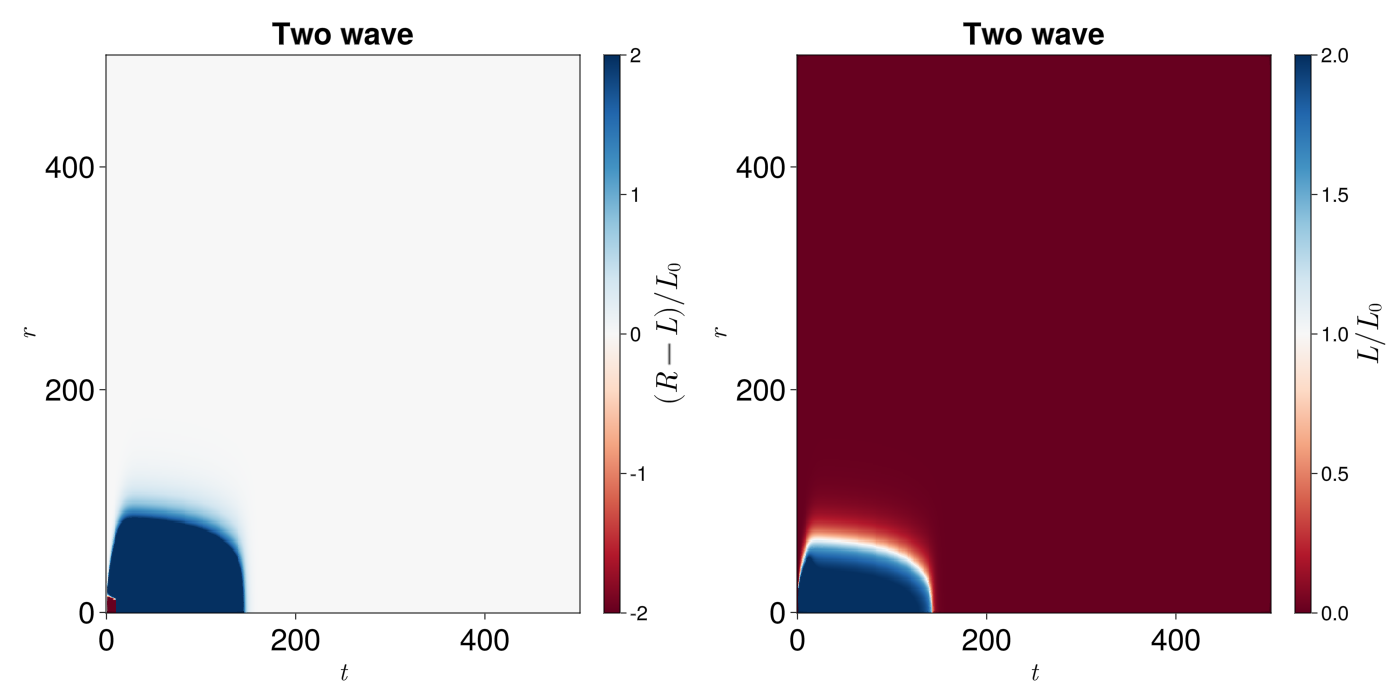

In [370]:
twowave_plane_sol = twowave_2d3d_sol[translate_2d3d_to_1d.(1:N_r,ceil(Int,N_z/2),N_r),:,:] #Get the solution at the z=0 plane
N_t = size(twowave_plane_sol, 3)
ts = 0:savedt:savedt*(N_t-1)
# Plotting the heatmap
fig = Figure(fontsize = 30, resolution = (1400, 700))
ax = Axis(fig[1,1],title="Two wave", xlabel = L"t", ylabel = L"r",xaxisposition = :bottom)
ax.xlabelsize = 25
ax.ylabelsize = 25
m = heatmap!(ax,ts, rgrid, (twowave_plane_sol[1:N_r,2,:].-twowave_plane_sol[1:N_r,1,:])'./L0, colormap=:RdBu,colorrange=(-2,2))
Colorbar(fig[1,2], m , vertical = true, label = L"(R-L)/L_0",ticklabelsize=20)

ax2 = Axis(fig[1,3],title="Two wave", xlabel = L"t", ylabel = L"r",xaxisposition = :bottom)
ax2.xlabelsize = 25
ax2.ylabelsize = 25
m2 = heatmap!(ax2,ts, rgrid, twowave_plane_sol[1:N_r,1,:]'./L0, colormap=:RdBu,colorrange=(0,2))
Colorbar(fig[1,4], m2 , vertical = true, label = L"L/L_0",ticklabelsize=20)
fig

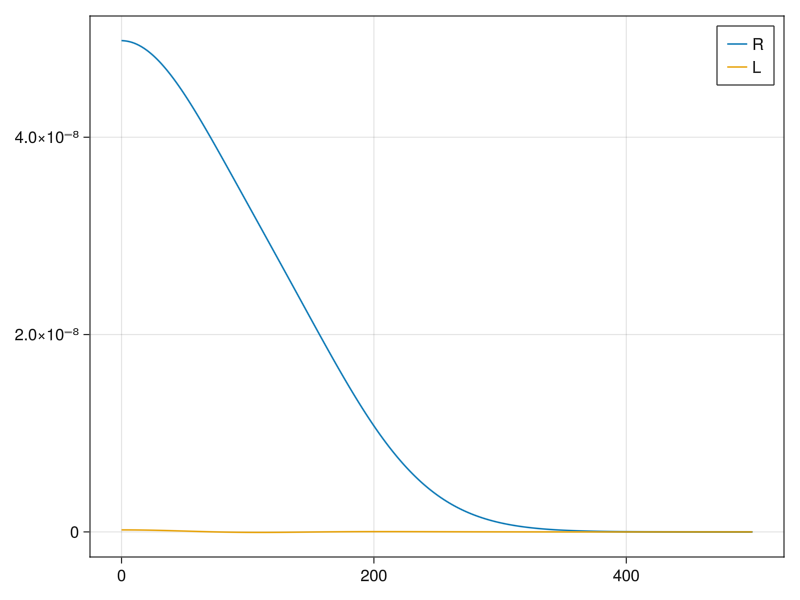

In [377]:
t_idx = 200
f = Figure()
ax = Axis(f[1, 1])
lines!(rgrid, twowave_plane_sol[1:N_r,2,t_idx]./L0, label="R",lw = 2)
lines!(rgrid, twowave_plane_sol[1:N_r,1,t_idx]./L0, label="L",lw = 2)
axislegend(ax, position = :rt, merge = true)
f

# Main text two threshold model
We want to simulate a model according to this equation: 
$$
\begin{aligned}
\frac{\partial L}{\partial t} &= D \nabla^2 L + a\rho \frac{I^m}{R^m + I^m} \frac{L^n}{L^n +L_0^n} - \gamma_L L \\
\frac{\partial R}{\partial t} &=  b \frac{L^k}{L^k+L_1^k} - \gamma_R L
\end{aligned}
$$
Note that this equation will be slightly different if cells are positioned on 2D plane and diffusion and degradation happens in 3D.

## Set the parameters and simulation space (2D-3D)

In [2]:
"""
    div_2d3d(N_r, N_z, r_max, z_max)

This function creates a Laplacian matrix for cells in 2D diffusion in 3D (cylindrical coordinates).

# Arguments
- `N_r`: Number of grid points in the radial direction.
- `N_z`: Number of grid points in the axial direction.
- `r_max`: Maximum value of the radial coordinate.
- `z_max`: Maximum value of the axial coordinate.

# Returns
- `mat_div`: Laplacian matrix for the given grid.

"""
function div_2d3d(N_r, N_z, r_max, z_max)
    rd = range(0, stop=r_max, length=N_r)
    zd = range(0, stop=z_max, length=N_z)
    dr = step(rd)
    dz = step(zd)
    translate_2d3d_to_1d(ir, iz) = (iz - 1) * N_r + ir
    ir_indices = Int[]
    jc_indices = Int[]
    data_values = Float64[]
    for ir in 1:N_r
        r = rd[ir]
        for iz in 1:N_z
            center_idx = translate_2d3d_to_1d(ir, iz)
            center_val = 0.
            # Radial parts
            if ir > 1 # Left neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir - 1, iz))
                push!(data_values, 1/dr^2 - 1/(2*dr*r))
            end
            if ir < N_r # Right neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir + 1, iz))
                if ir != 1
                    push!(data_values, 1/dr^2 + 1/(2*dr*r))
                else
                    push!(data_values, 1/dr^2)
                end
                # push!(data_values, 1/dr^2 + 1/(2*dr*r))
            end
            if ir != 1
                center_val -= 1/(dr^2)
            end

            # Axial parts
            if iz > 1 # Below neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir, iz - 1))
                push!(data_values, 1/dz^2)
            end
            if iz < N_z # Above neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir, iz + 1))
                push!(data_values, 1/dz^2)
            end

            # Center position, adjusted for radial dependence
            center_val -= (1/dr^2 + 2/dz^2) 
            push!(ir_indices, center_idx)
            push!(jc_indices, center_idx)
            push!(data_values, center_val)
        end
    end

    # Construct the sparse matrix
    mat_div = sparse(ir_indices, jc_indices, data_values)
    return mat_div
end

div_2d3d

In [81]:


#Environment setup: 
l_mul = 10 #length unit multiplier, changing it won't affect the results
t_mul = 100 #time unit multiplier, changing it won't affect the results
r_limit = 50*l_mul #500 microns in simulation radius
z_limit = 5*l_mul #500 microns in simulation height (in this model the co-permissive cue diffuses more rapidly so it needs higher z_limit)
r_cell = 0.015*l_mul # 0.15 micron is the simulation grid size
r_inputsource = 1*l_mul # 10 microns is the source size
H = 0.1*l_mul # 1 micron is the source height
N_r = 500 # 400
N_z = 125 # 500
mat_div = div_2d3d(N_r,N_z,r_limit,z_limit);
rgrid = range(0,stop = r_limit,length = N_r)
zgrid = range(0,stop = z_limit, length = N_z)

dr = step(rgrid)
dz = step(zgrid)

zs = repeat(zgrid,inner = N_r)
ir_max = ceil(Int,r_inputsource/dr)+1
iz_min = floor(Int,(z_limit/2 - H/2)/dz)
iz_max = floor(Int,(z_limit/2 + H/2)/dz)+1

delta(z,H) = 1/(2H)*sqrt(2/pi)*exp(-z^2 / (2*H^2)); #1D Gaussian distribution, function to mimic delta function on the z axis
deltaz_vec = delta.(zs .- z_limit/2,H)
deltar(r,R) = 1/(R^2)*exp(-r^2 /(R^2)); #2D Gaussian distribution in polar coordinates
source_T(t,S0,S_l) = (t >= 0)*(t <= S_l)*S0;

translate_2d3d_to_1d(ir,iz,N_r) = (iz - 1)*N_r + ir;


"""
    hill_f(N, K, h)

Compute the Hill function value for given parameters.

# Arguments
- `N`: The input value.
- `K`: The Hill coefficient.
- `h`: The Hill exponent.

# Returns
- The computed Hill function value.

"""
function hill_f(N,K,h)
    if h > 0
        return N^h /(N^h + K^h)
    else
        return 1*(N > K)
    end
end
function gill_f(N,K,h)
    if h > 0
        return K^h/(N^h + K^h)
    else
        return 1*(N < K)
    end
end
function twothreshold_2d3d_diff(dX,X,ps,t)
    # ODEs with hill functions
    D, a, rho, gammaL, gammaR, L0, L1, b, I, S_on, S_len = ps 
    # D = D/(dx^2)
    @inbounds dX[:,1] =  D*mat_div*X[:,1] .+ a*rho.*gill_f.(X[:,2],I,3).*hill_f.(X[:,1],L0,3).*deltaz_vec*2 .- gammaL*X[:,1]
    @inbounds dX[:,2] = b*hill_f.(X[:,1],L1,5) - gammaR*X[:,2]
    if S_on > 0. && t < S_len
        @inbounds for ir in 1:ir_max
        for iz in iz_min:iz_max
            dX[translate_2d3d_to_1d(ir,iz,N_r),1] += S_on
        end
        end
    end
end


function init_2d3d(rd,zd,S_int,r_source, R0)
    #initialization of the concentration field
    N_r = length(rd)
    N_z = length(zd)
    source_Trz(r,z,t,S0) = deltar(r,r_source)*delta(z - z_limit/2,H)*(t >= 0)*S0; #source in the center
    u = zeros(N_r*N_z,2)
    for I in CartesianIndices((N_r, N_z))
        r = rd[I[1]]
        z = zd[I[2]]
        u[translate_2d3d_to_1d(I[1],I[2],N_r),1] = source_Trz(r,z,1.,S_int)
        u[translate_2d3d_to_1d(I[1],I[2],N_r),2] = R0
    #   u[I] = 27*(x*(1-x))^(3/2)
    end
    u
end

#Step size
dr = step(rgrid);
dz = step(zgrid);

D = 0.07*1e3*l_mul^2 /t_mul # mm^2/min
#Cond set:
b = 1/(t_mul) #Inhibition rate 
I = 0.15#Inhibition shutoff threshold

gammaL = 0.2/t_mul #Decay rate #gammaL 0.1
gammaR = 0.1/t_mul#Decay rate #gammaR 0.1
#Units are scaled but otherwise set here: 
a = 1/t_mul #Relay strength term, effectively (a*p from paul model) a = 0.025*t_mul*l_mul^2 

sam = 1e4 #Input source strength, without units, 0 means no input after initialization
S_duration = 0.5*t_mul #Duration of input source

rho = 1.0/l_mul^2 #2D density of cells
S_on = sam/(t_mul^2*l_mul^3) #Input strength, constant emmisssion, with units
L0 = 0.0075/l_mul^3 #Relay threshold

#Inhibition Terms: 
L1 = L0/100 #Inhibitor production threshold
# L1 = 3*L0

#Parameter set to pass to model
ps_temp = D, a, rho, gammaL, gammaR, L0, L1, b, I, S_on, S_duration #For LTB4_relay_gdecay_practical_2d3d_diff

# ps_temp = (DL, a, gammaL, L0, L1, b, I, rho, S_on, S_duration) #For LTB4_relay_gdecay_pedagogical_2d3d_diff


r_source = 3*l_mul #Initial source size
s_init = 0.#Initial source amplitude
#Setting initatal conditions and building model space: 
X02d3d = init_2d3d(rgrid, zgrid, s_init, r_source, 0.0);
dX02d3d= copy(X02d3d);


In [12]:
jac_sparsity_2d3d_twothreshold = Symbolics.jacobian_sparsity((dX,X)->twothreshold_2d3d_diff(dX,X,ps_temp,1),dX02d3d,X02d3d); # For utlizing sparsity in the Jacobian

## Running the simulation

In [82]:
#solve the model
t_end = 5.0*t_mul
savedt = 0.01*t_mul
f3 = ODEFunction(twothreshold_2d3d_diff;jac_prototype=float.(jac_sparsity_2d3d_twothreshold));
twothreshold_2d3d_sparse = ODEProblem(f3,X02d3d,(0.0,t_end),ps_temp); #Setup ODE problem:
twothreshold_2d3d_sol = solve(twothreshold_2d3d_sparse, Rodas5P(), saveat = savedt); 

## View the results

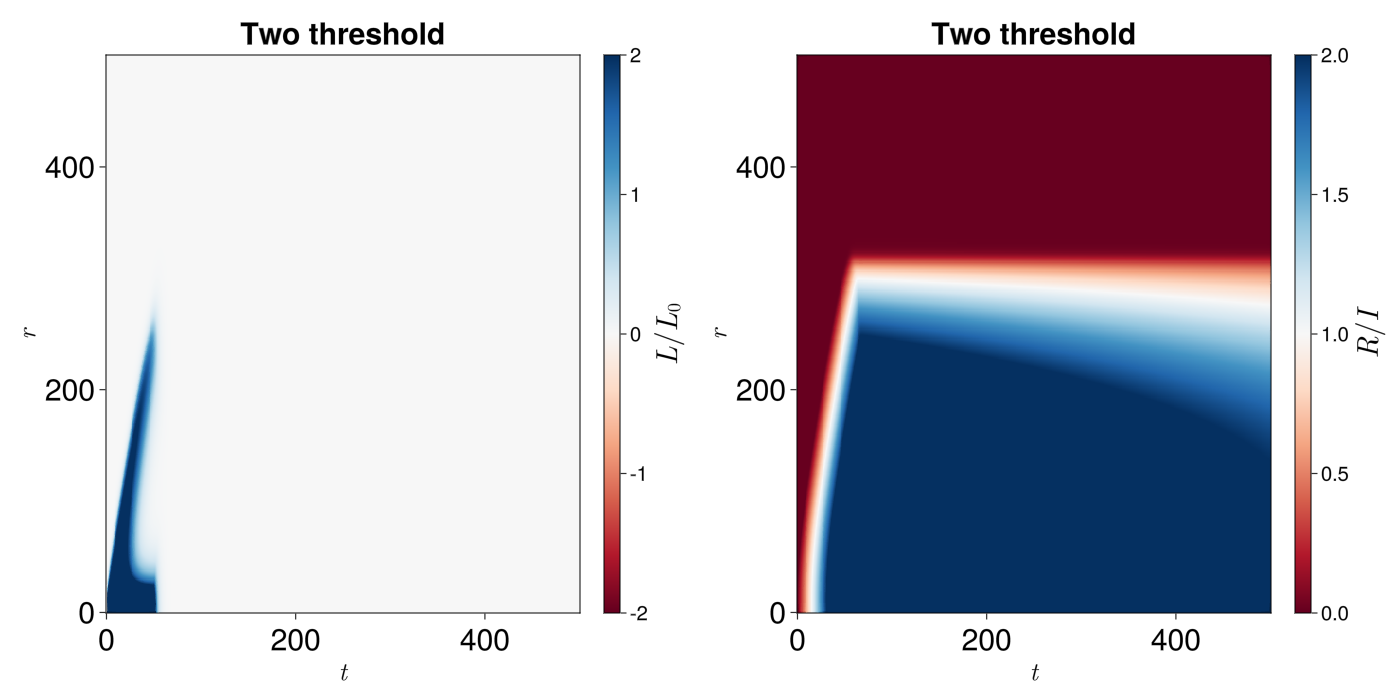

In [83]:
twothreshold_plane_sol = twothreshold_2d3d_sol[translate_2d3d_to_1d.(1:N_r,ceil(Int,N_z/2),N_r),:,:] #Get the solution at the z=0 plane
N_t = size(twothreshold_plane_sol, 3)
ts = 0:savedt:savedt*(N_t-1)
# Plotting the heatmap
fig = Figure(fontsize = 30, resolution = (1400, 700))
ax = Axis(fig[1,1],title="Two threshold", xlabel = L"t", ylabel = L"r",xaxisposition = :bottom)
ax.xlabelsize = 25
ax.ylabelsize = 25
m = heatmap!(ax,ts, rgrid, twothreshold_plane_sol[1:N_r,1,:]'./L0, colormap=:RdBu,colorrange=(-2,2))
Colorbar(fig[1,2], m , vertical = true, label = L"L/L_0",ticklabelsize=20)

ax2 = Axis(fig[1,3],title="Two threshold", xlabel = L"t", ylabel = L"r",xaxisposition = :bottom)
ax2.xlabelsize = 25
ax2.ylabelsize = 25
m2 = heatmap!(ax2,ts, rgrid, twothreshold_plane_sol[1:N_r,2,:]'./I, colormap=:RdBu,colorrange=(0,2))
Colorbar(fig[1,4], m2 , vertical = true, label = L"R/I",ticklabelsize=20)
fig

# Two threshold model with diffusive inhibitor
We want to simulate a model according to this equation: 
$$
\begin{aligned}
\frac{\partial L}{\partial t} &= D \nabla^2 L + a\rho \frac{I^m}{R^m + I^m} \frac{L^n}{L^n +L_0^n} - \gamma_L L \\
\frac{\partial R}{\partial t} &= D\nabla^2 R + b \frac{L^k}{L^k+L_1^k} - \gamma_R L
\end{aligned}
$$
Note that this equation will be slightly different if cells are positioned on 2D plane and diffusion and degradation happens in 3D.

## Set the parameters and simulation space (2D-3D)

In [2]:
"""
    div_2d3d(N_r, N_z, r_max, z_max)

This function creates a Laplacian matrix for cells in 2D diffusion in 3D (cylindrical coordinates).

# Arguments
- `N_r`: Number of grid points in the radial direction.
- `N_z`: Number of grid points in the axial direction.
- `r_max`: Maximum value of the radial coordinate.
- `z_max`: Maximum value of the axial coordinate.

# Returns
- `mat_div`: Laplacian matrix for the given grid.

"""
function div_2d3d(N_r, N_z, r_max, z_max)
    rd = range(0, stop=r_max, length=N_r)
    zd = range(0, stop=z_max, length=N_z)
    dr = step(rd)
    dz = step(zd)
    translate_2d3d_to_1d(ir, iz) = (iz - 1) * N_r + ir
    ir_indices = Int[]
    jc_indices = Int[]
    data_values = Float64[]
    for ir in 1:N_r
        r = rd[ir]
        for iz in 1:N_z
            center_idx = translate_2d3d_to_1d(ir, iz)
            center_val = 0.
            # Radial parts
            if ir > 1 # Left neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir - 1, iz))
                push!(data_values, 1/dr^2 - 1/(2*dr*r))
            end
            if ir < N_r # Right neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir + 1, iz))
                if ir != 1
                    push!(data_values, 1/dr^2 + 1/(2*dr*r))
                else
                    push!(data_values, 1/dr^2)
                end
                # push!(data_values, 1/dr^2 + 1/(2*dr*r))
            end
            if ir != 1
                center_val -= 1/(dr^2)
            end

            # Axial parts
            if iz > 1 # Below neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir, iz - 1))
                push!(data_values, 1/dz^2)
            end
            if iz < N_z # Above neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, translate_2d3d_to_1d(ir, iz + 1))
                push!(data_values, 1/dz^2)
            end

            # Center position, adjusted for radial dependence
            center_val -= (1/dr^2 + 2/dz^2) 
            push!(ir_indices, center_idx)
            push!(jc_indices, center_idx)
            push!(data_values, center_val)
        end
    end

    # Construct the sparse matrix
    mat_div = sparse(ir_indices, jc_indices, data_values)
    return mat_div
end

div_2d3d

In [20]:


#Environment setup: 
l_mul = 10 #length unit multiplier, changing it won't affect the results
t_mul = 100 #time unit multiplier, changing it won't affect the results
r_limit = 50*l_mul #500 microns in simulation radius
z_limit = 5*l_mul #500 microns in simulation height (in this model the co-permissive cue diffuses more rapidly so it needs higher z_limit)
r_cell = 0.015*l_mul # 0.15 micron is the simulation grid size
r_inputsource = 1*l_mul # 10 microns is the source size
H = 0.1*l_mul # 1 micron is the source height
N_r = 500 # 400
N_z = 125 # 500
mat_div = div_2d3d(N_r,N_z,r_limit,z_limit);
rgrid = range(0,stop = r_limit,length = N_r)
zgrid = range(0,stop = z_limit, length = N_z)

dr = step(rgrid)
dz = step(zgrid)

zs = repeat(zgrid,inner = N_r)
ir_max = ceil(Int,r_inputsource/dr)+1
iz_min = floor(Int,(z_limit/2 - H/2)/dz)
iz_max = floor(Int,(z_limit/2 + H/2)/dz)+1

delta(z,H) = 1/(2H)*sqrt(2/pi)*exp(-z^2 / (2*H^2)); #1D Gaussian distribution, function to mimic delta function on the z axis
deltaz_vec = delta.(zs .- z_limit/2,H)
deltar(r,R) = 1/(R^2)*exp(-r^2 /(R^2)); #2D Gaussian distribution in polar coordinates
source_T(t,S0,S_l) = (t >= 0)*(t <= S_l)*S0;

translate_2d3d_to_1d(ir,iz,N_r) = (iz - 1)*N_r + ir;


"""
    hill_f(N, K, h)

Compute the Hill function value for given parameters.

# Arguments
- `N`: The input value.
- `K`: The Hill coefficient.
- `h`: The Hill exponent.

# Returns
- The computed Hill function value.

"""
function hill_f(N,K,h)
    if h > 0
        return N^h /(N^h + K^h)
    else
        return 1*(N > K)
    end
end
function gill_f(N,K,h)
    if h > 0
        return K^h/(N^h + K^h)
    else
        return 1*(N < K)
    end
end
function twothreshold_diffuseR_2d3d_diff(dX,X,ps,t)
    # ODEs with hill functions
    D, a, rho, gammaL, gammaR, L0, L1, b, I, S_on, S_len = ps 
    # D = D/(dx^2)
    @inbounds dX[:,1] =  D*mat_div*X[:,1] .+ a*rho.*gill_f.(X[:,2],I,3).*hill_f.(X[:,1],L0,3).*deltaz_vec*2 .- gammaL*X[:,1]
    @inbounds dX[:,2] = D*mat_div*X[:,2] .+ b*rho*hill_f.(X[:,1],L1,5).*deltaz_vec*2 - gammaR*X[:,2]
    if S_on > 0. && t < S_len
        @inbounds for ir in 1:ir_max
        for iz in iz_min:iz_max
            dX[translate_2d3d_to_1d(ir,iz,N_r),1] += S_on
        end
        end
    end
end


function init_2d3d(rd,zd,S_int,r_source, R0)
    #initialization of the concentration field
    N_r = length(rd)
    N_z = length(zd)
    source_Trz(r,z,t,S0) = deltar(r,r_source)*delta(z - z_limit/2,H)*(t >= 0)*S0; #source in the center
    u = zeros(N_r*N_z,2)
    for I in CartesianIndices((N_r, N_z))
        r = rd[I[1]]
        z = zd[I[2]]
        u[translate_2d3d_to_1d(I[1],I[2],N_r),1] = source_Trz(r,z,1.,S_int)
        u[translate_2d3d_to_1d(I[1],I[2],N_r),2] = R0
    #   u[I] = 27*(x*(1-x))^(3/2)
    end
    u
end

#Step size
dr = step(rgrid);
dz = step(zgrid);

D = 0.07*1e3*l_mul^2 /t_mul # mm^2/min
#Cond set:
b = 4.5/(t_mul) #Inhibition rate 
I = 0.15/l_mul^3#Inhibition shutoff threshold

gammaL = 0.2/t_mul #Decay rate #gammaL 0.1
gammaR = 0.1/t_mul#Decay rate #gammaR 0.1
#Units are scaled but otherwise set here: 
a = 1/t_mul #Relay strength term, effectively (a*p from paul model) a = 0.025*t_mul*l_mul^2 

sam = 1e4 #Input source strength, without units, 0 means no input after initialization
S_duration = 0.5*t_mul #Duration of input source

rho = 1.0/l_mul^2 #2D density of cells
S_on = sam/(t_mul^2*l_mul^3) #Input strength, constant emmisssion, with units
L0 = 0.0075/l_mul^3 #Relay threshold

#Inhibition Terms: 
L1 = L0/100 #Inhibitor production threshold
# L1 = 3*L0

#Parameter set to pass to model
ps_temp = D, a, rho, gammaL, gammaR, L0, L1, b, I, S_on, S_duration #For LTB4_relay_gdecay_practical_2d3d_diff

# ps_temp = (DL, a, gammaL, L0, L1, b, I, rho, S_on, S_duration) #For LTB4_relay_gdecay_pedagogical_2d3d_diff


r_source = 3*l_mul #Initial source size
s_init = 0.#Initial source amplitude
#Setting initatal conditions and building model space: 
X02d3d = init_2d3d(rgrid, zgrid, s_init, r_source, 0.0);
dX02d3d= copy(X02d3d);


In [4]:
jac_sparsity_2d3d_twothreshold_diffuseR = Symbolics.jacobian_sparsity((dX,X)->twothreshold_diffuseR_2d3d_diff(dX,X,ps_temp,1),dX02d3d,X02d3d); # For utlizing sparsity in the Jacobian

## Running the simulation

In [21]:
#solve the model
t_end = 5.0*t_mul
savedt = 0.01*t_mul
f4 = ODEFunction(twothreshold_diffuseR_2d3d_diff;jac_prototype=float.(jac_sparsity_2d3d_twothreshold_diffuseR));
twothreshold_diffuseR_2d3d_sparse = ODEProblem(f4,X02d3d,(0.0,t_end),ps_temp); #Setup ODE problem:
twothreshold_diffuseR_2d3d_sol = solve(twothreshold_diffuseR_2d3d_sparse, Rodas5P(), saveat = savedt); 

## View the results

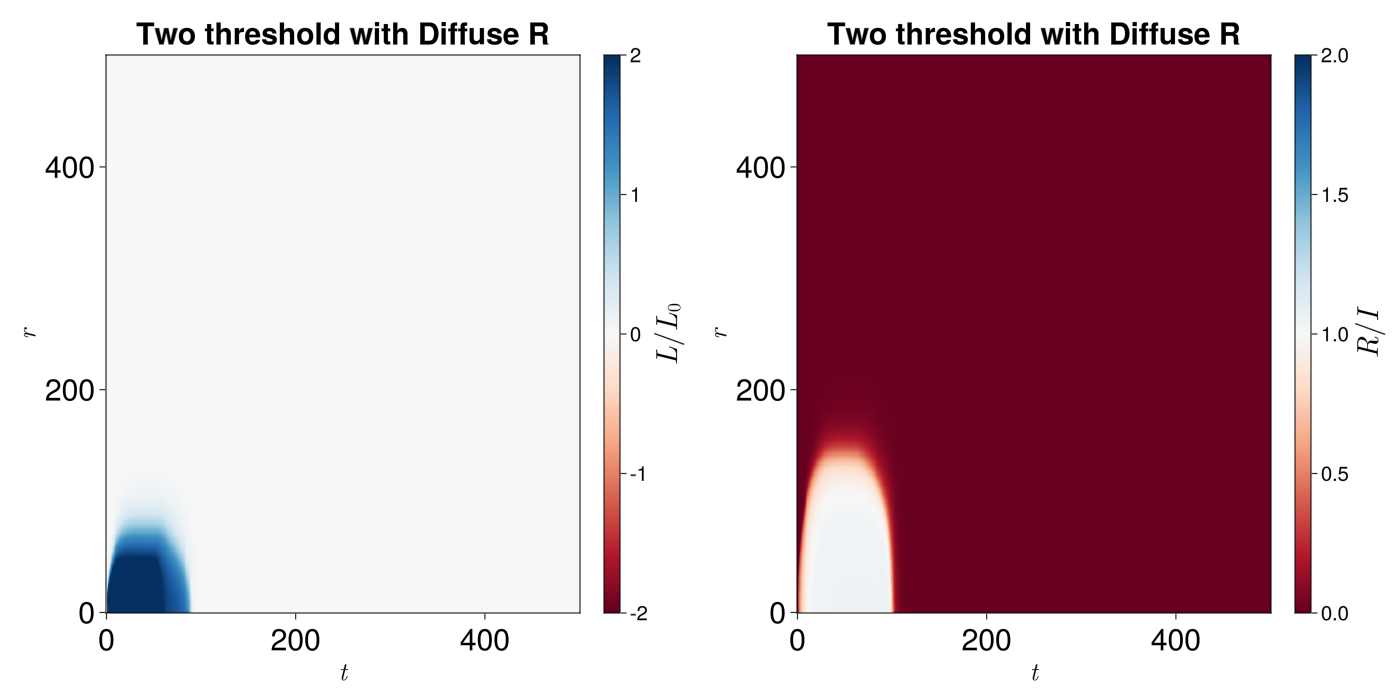

In [22]:
twothreshold_diffuseR_plane_sol = twothreshold_diffuseR_2d3d_sol[translate_2d3d_to_1d.(1:N_r,ceil(Int,N_z/2),N_r),:,:] #Get the solution at the z=0 plane
N_t = size(twothreshold_diffuseR_plane_sol, 3)
ts = 0:savedt:savedt*(N_t-1)
# Plotting the heatmap
fig = Figure(fontsize = 30, resolution = (1400, 700))
ax = Axis(fig[1,1],title="Two threshold with Diffuse R", xlabel = L"t", ylabel = L"r",xaxisposition = :bottom)
ax.xlabelsize = 25
ax.ylabelsize = 25
m = heatmap!(ax,ts, rgrid, twothreshold_diffuseR_plane_sol[1:N_r,1,:]'./L0, colormap=:RdBu,colorrange=(-2,2))
Colorbar(fig[1,2], m , vertical = true, label = L"L/L_0",ticklabelsize=20)

ax2 = Axis(fig[1,3],title="Two threshold with Diffuse R", xlabel = L"t", ylabel = L"r",xaxisposition = :bottom)
ax2.xlabelsize = 25
ax2.ylabelsize = 25
m2 = heatmap!(ax2,ts, rgrid, twothreshold_diffuseR_plane_sol[1:N_r,2,:]'./I, colormap=:RdBu,colorrange=(0,2))
Colorbar(fig[1,4], m2 , vertical = true, label = L"R/I",ticklabelsize=20)
fig